In [35]:
#!pip install catboost

In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC # "Support vector classifier"  

In [37]:
def plot_diagram(p , features):
  for f in features:
    print(f)
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    sns.displot(p[f])    # Only change distplot to displot
    plt.show()
    print('\n')

def is_categorical(array_like):
    print(array_like.dtype.name)
    return array_like.dtype.name == 'category' or array_like.dtype.name == 'object'

def plot_diagram_categorical(p , feature):
  sns.catplot(x=feature, y='Churn', data=p[feature])

def outliers_plot(p):
  plt.style.use('ggplot') # Using ggplot2 style visuals 
  f, ax = plt.subplots(figsize=(11, 18))
  ax.set_facecolor('#fafafa')
  ax.set(xlim=(-.05, 200))
  plt.ylabel('Variables')
  plt.title("Overview Data Set")
  ax = sns.boxplot(data = p, 
    orient = 'h', 
    palette = 'Set2')
  
def iqr(df , features):
  for f in features:
    mean = df[f].mean()
    Q1 = df[f].quantile(0.25)
    Q3 = df[f].quantile(0.75)
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    df[f] = np.where(df[f] <lower_range,lower_range ,df[f])
    df[f] = np.where(df[f] >upper_range, upper_range,df[f])
  return df

In [38]:
chatterbox = pd.read_csv('Data/churn_dataset.csv', engine='python')

In [39]:
chatterbox.describe()

,customer_id,account_length,location_code,number_vm_messages,total_day_min,total_day_calls,total_day_charge,total_eve_min,total_eve_calls,total_eve_charge,...,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,service quality,priority customer level,total data usage,network coverage,total messages usage
count,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,425551.500000,100.25860,436.911400,7.755200,180.288900,100.029400,30.649668,200.636560,100.191000,17.054322,...,9.017732,10.261780,4.435200,2.771196,1.570400,4.56640,1.867000,31.128000,518.033200,395.511800
std,1443.520003,39.69456,42.209182,13.546393,53.894699,19.831197,9.162069,50.551309,19.826496,4.296843,...,2.273763,2.761396,2.456788,0.745514,1.306363,3.24803,0.835135,21.226505,258.073916,171.535575
min,423052.000000,1.00000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,100.000000,120.000000
25%,424301.750000,73.00000,408.000000,0.000000,143.700000,87.000000,24.430000,166.375000,87.000000,14.140000,...,7.510000,8.500000,3.000000,2.300000,1.000000,0.00000,1.000000,10.000000,298.000000,249.000000
50%,425551.500000,100.00000,415.000000,0.000000,180.100000,100.000000,30.620000,201.000000,100.000000,17.090000,...,9.020000,10.300000,4.000000,2.780000,1.000000,5.00000,2.000000,30.000000,489.000000,379.000000
75%,426801.250000,127.00000,415.000000,17.000000,216.200000,113.000000,36.750000,234.100000,114.000000,19.900000,...,10.560000,12.000000,6.000000,3.240000,2.000000,7.00000,3.000000,50.000000,737.250000,540.000000
max,428051.000000,243.00000,510.000000,52.000000,351.500000,165.000000,59.760000,363.700000,170.000000,30.910000,...,17.770000,20.000000,20.000000,5.400000,9.000000,9.00000,3.000000,69.000000,999.000000,719.000000


In [40]:
chatterbox.shape

(5000, 27)

# **Data Pre-processing**

Dropping Duplicates

In [41]:
chatterbox = chatterbox.drop_duplicates()

In [42]:
chatterbox.dtypes

customer_id                  int64
State                       object
account_length               int64
location_code                int64
Phone Number                object
intertiol_plan              object
voice_mail_plan             object
number_vm_messages           int64
total_day_min              float64
total_day_calls              int64
total_day_charge           float64
total_eve_min              float64
total_eve_calls              int64
total_eve_charge           float64
total_night_minutes        float64
total_night_calls            int64
total_night_charge         float64
total_intl_minutes         float64
total_intl_calls             int64
total_intl_charge          float64
customer_service_calls       int64
service quality              int64
priority customer level      int64
total data usage             int64
network coverage             int64
total messages usage         int64
Churn                       object
dtype: object

Cleaning Data

In [43]:
customer_id_temp = chatterbox['customer_id']
chatterbox = chatterbox.drop(columns=['customer_id', 'Phone Number'])

y = 'Churn'
obj_features = ['State','location_code', 'intertiol_plan' , 'voice_mail_plan', 'Churn']
num_features = list(set(chatterbox.columns) - set(obj_features))

In [44]:
chatterbox.isnull().sum()

State                      0
account_length             0
location_code              0
intertiol_plan             0
voice_mail_plan            0
number_vm_messages         0
total_day_min              0
total_day_calls            0
total_day_charge           0
total_eve_min              0
total_eve_calls            0
total_eve_charge           0
total_night_minutes        0
total_night_calls          0
total_night_charge         0
total_intl_minutes         0
total_intl_calls           0
total_intl_charge          0
customer_service_calls     0
service quality            0
priority customer level    0
total data usage           0
network coverage           0
total messages usage       0
Churn                      0
dtype: int64

In [45]:
chatterbox['location_code'].replace(to_replace=445.0, value=0, inplace=True)
chatterbox['location_code'].replace(to_replace=452.0,  value=1, inplace=True)
chatterbox['location_code'].replace(to_replace=547.0,  value=2, inplace=True)

In [46]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
chatterbox['State']= label_encoder.fit_transform(chatterbox['State'])
chatterbox['Churn']= label_encoder.fit_transform(chatterbox['Churn'])
chatterbox['intertiol_plan']= label_encoder.fit_transform(chatterbox['intertiol_plan'])
chatterbox['voice_mail_plan']= label_encoder.fit_transform(chatterbox['voice_mail_plan'])

In [47]:
# Checking for negative Values
for f in num_features:
  chatterbox[f] = np.where(chatterbox[f] < 0, np.NaN , chatterbox[f])

for f in num_features:
    median=chatterbox[f].median()
    chatterbox[f].fillna(value=median, inplace=True)
    
for f in obj_features:
    mode=chatterbox[f].mode()[0]
    chatterbox[f].fillna(value=mode, inplace=True)

In [48]:
chatterbox.isnull().sum()

State                      0
account_length             0
location_code              0
intertiol_plan             0
voice_mail_plan            0
number_vm_messages         0
total_day_min              0
total_day_calls            0
total_day_charge           0
total_eve_min              0
total_eve_calls            0
total_eve_charge           0
total_night_minutes        0
total_night_calls          0
total_night_charge         0
total_intl_minutes         0
total_intl_calls           0
total_intl_charge          0
customer_service_calls     0
service quality            0
priority customer level    0
total data usage           0
network coverage           0
total messages usage       0
Churn                      0
dtype: int64

total_night_charge


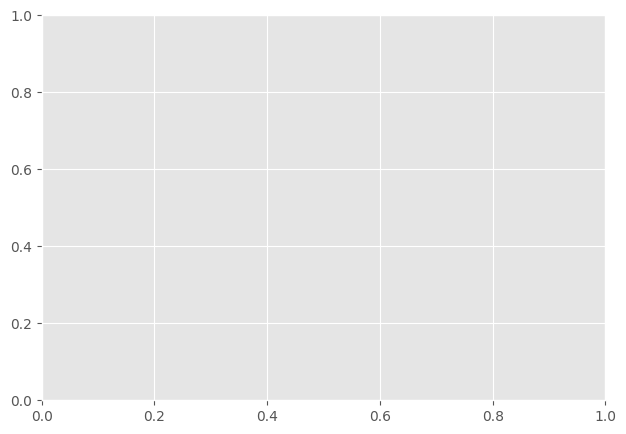

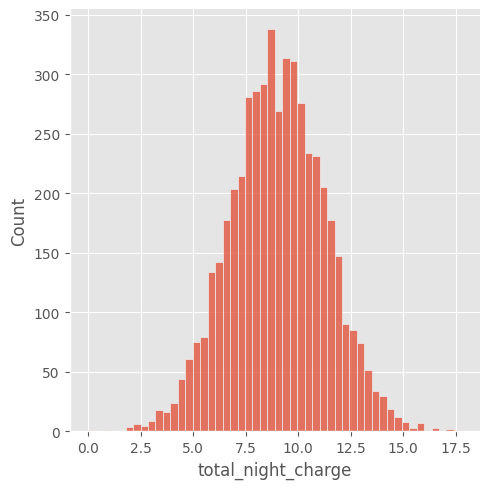



total_eve_min


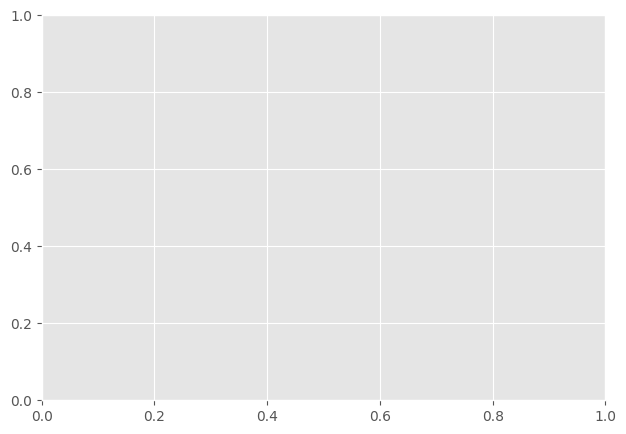

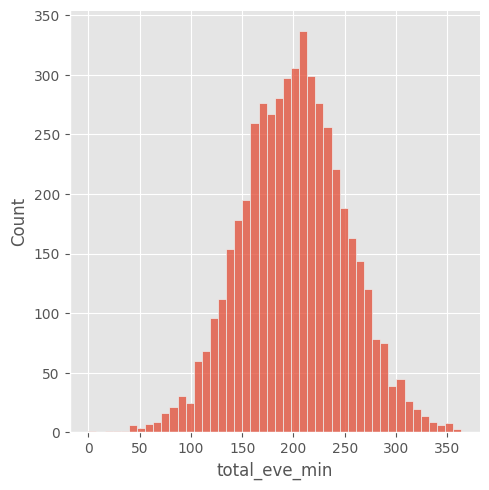



total_night_minutes


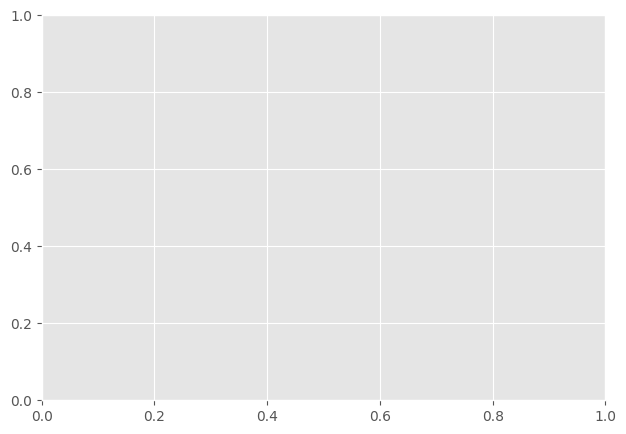

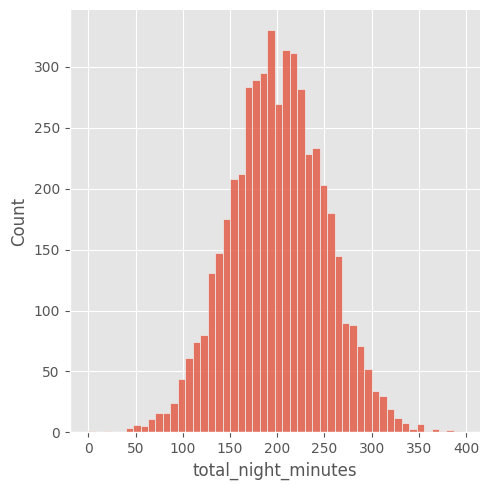



total_intl_calls


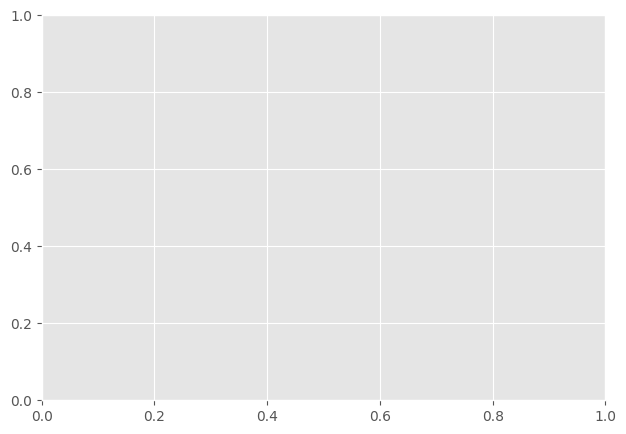

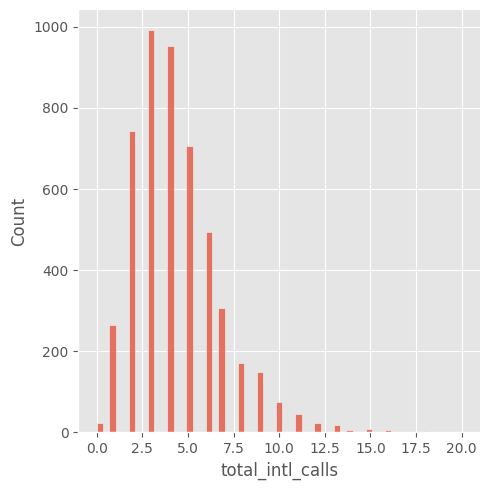



total_night_calls


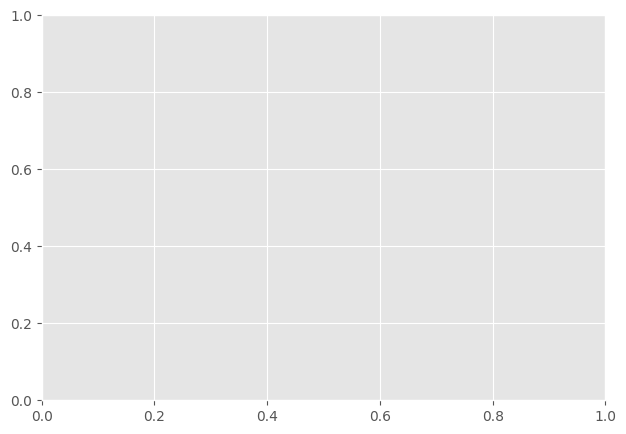

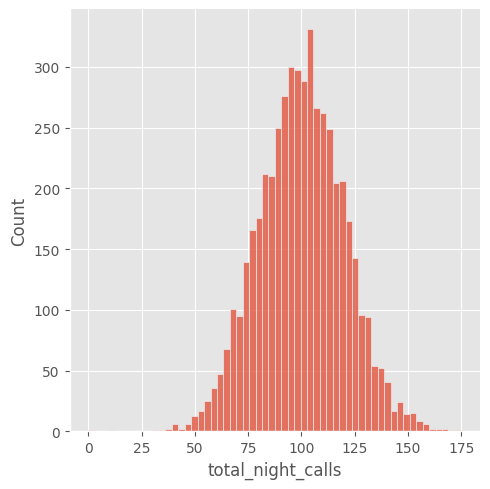



network coverage


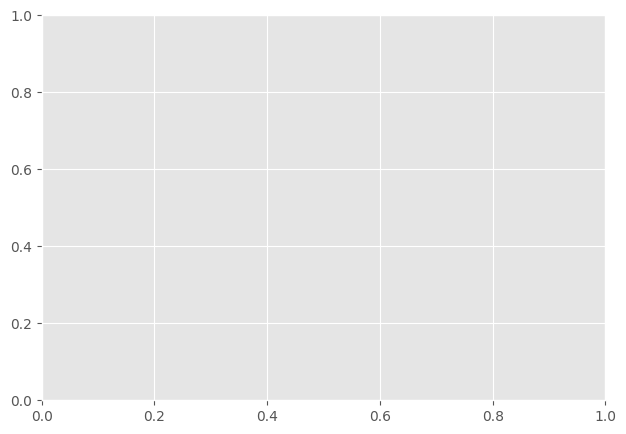

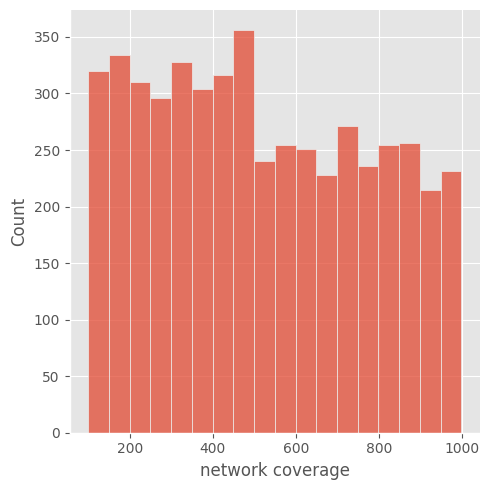



total_day_charge


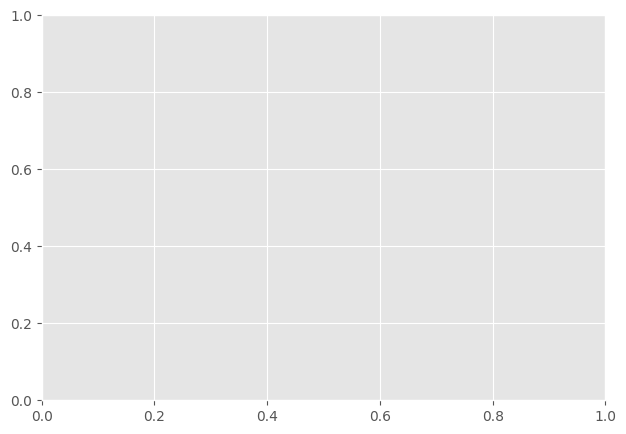

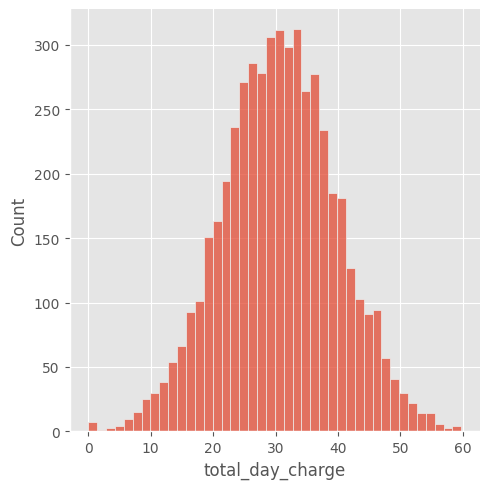



total_eve_charge


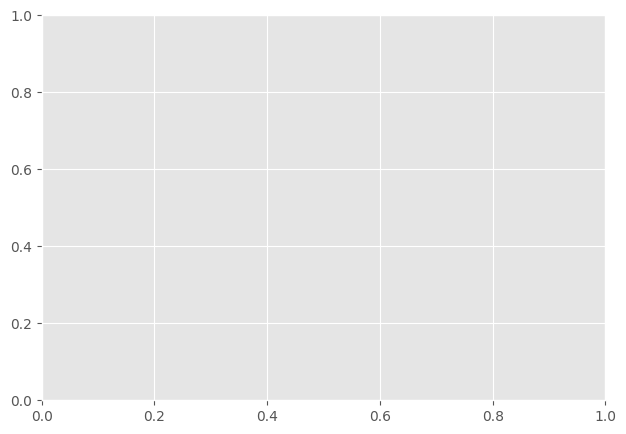

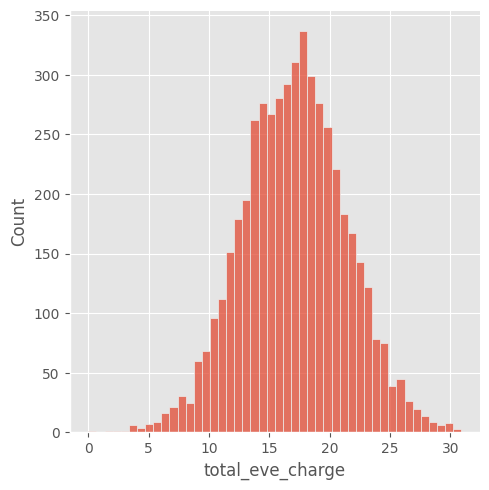



total_day_min


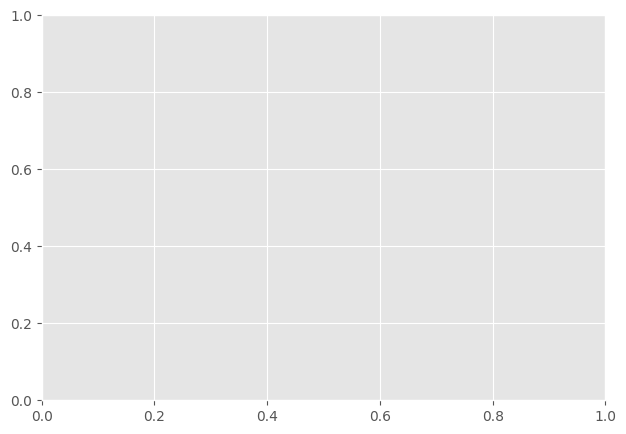

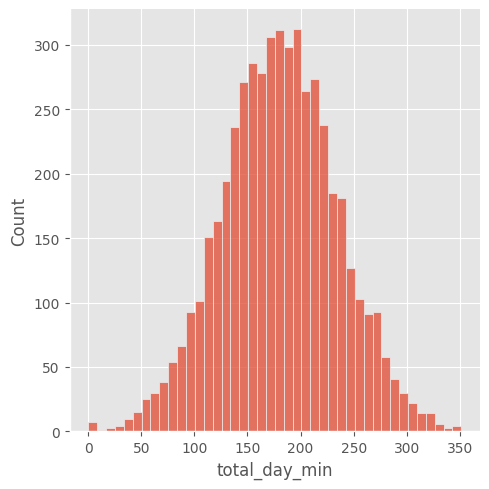



total_intl_charge


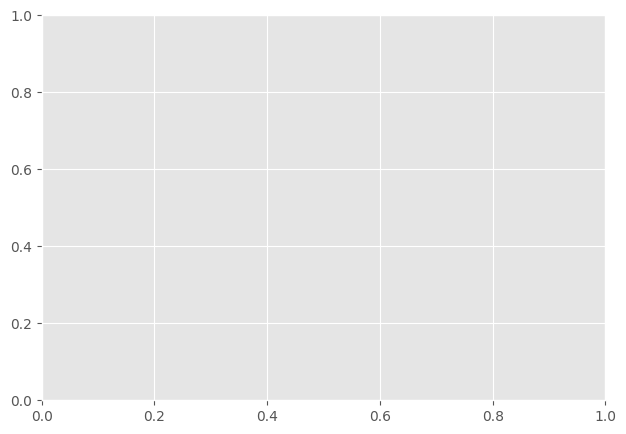

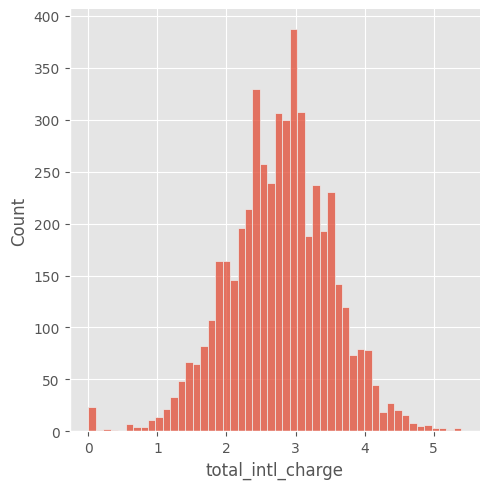



total_eve_calls


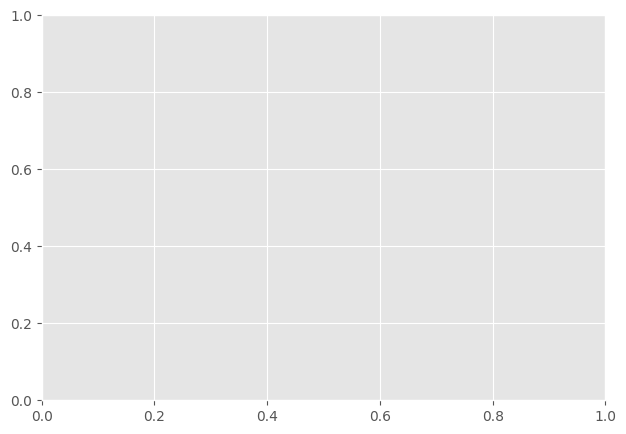

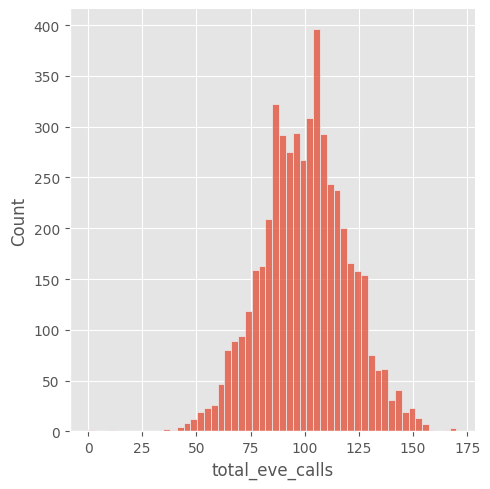



total_intl_minutes


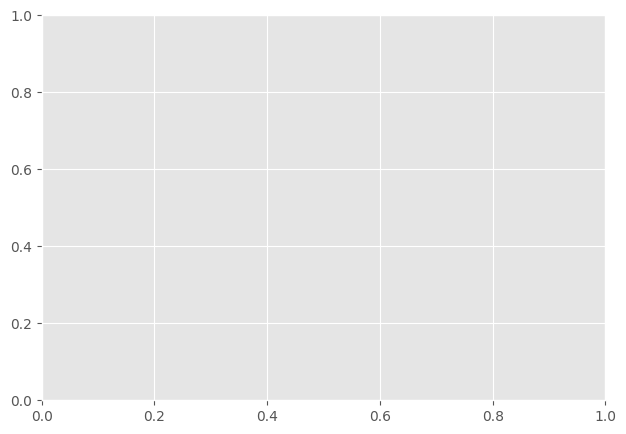

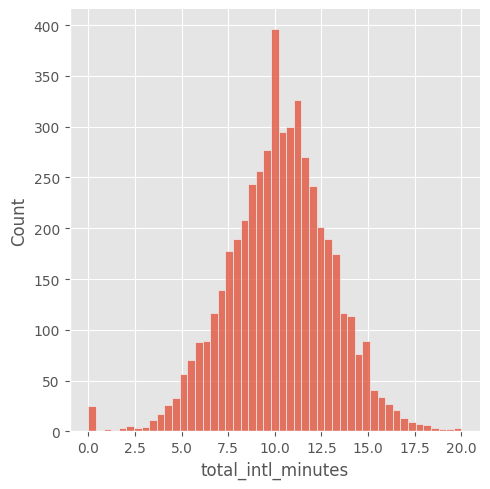



total data usage


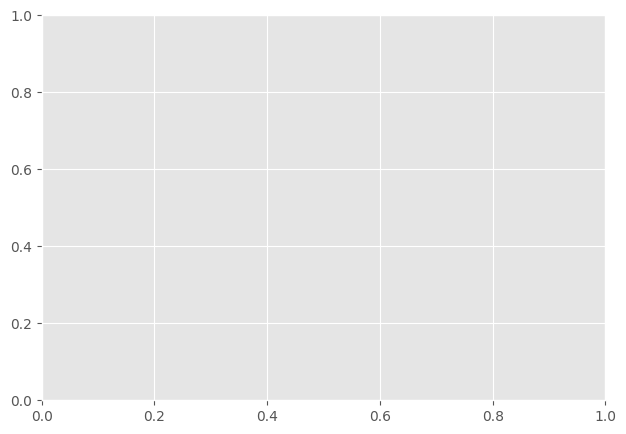

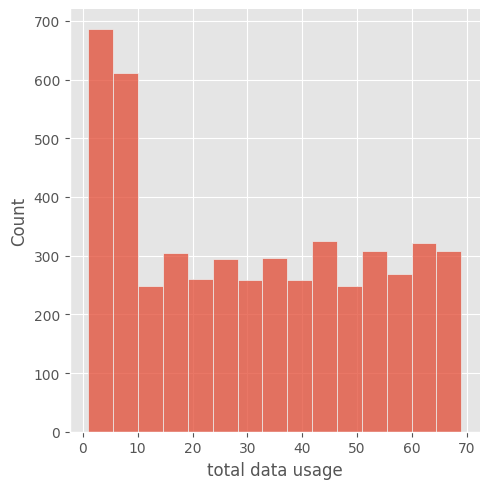



total messages usage


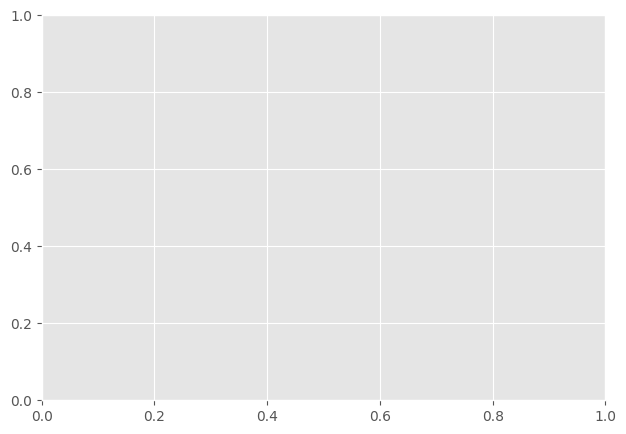

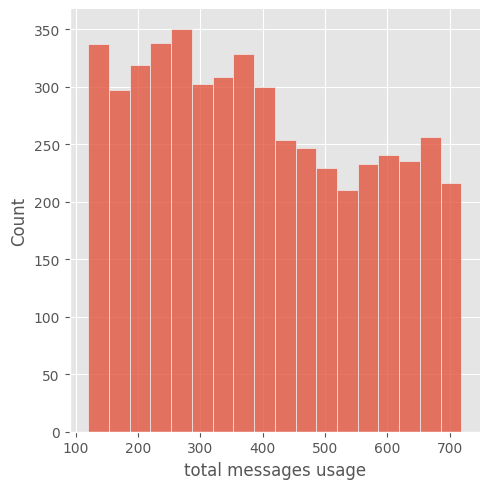



priority customer level


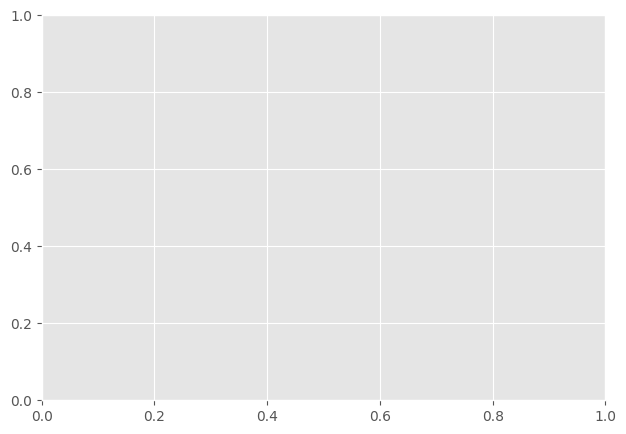

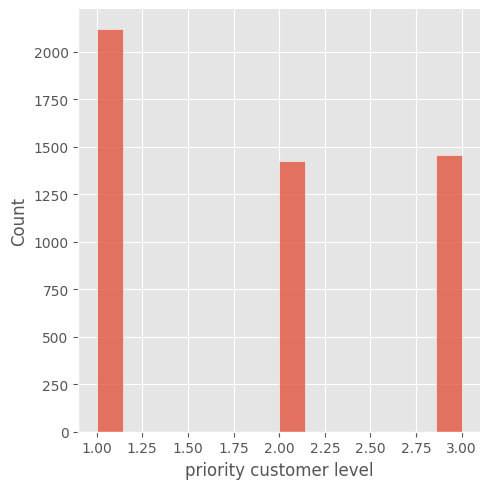



number_vm_messages


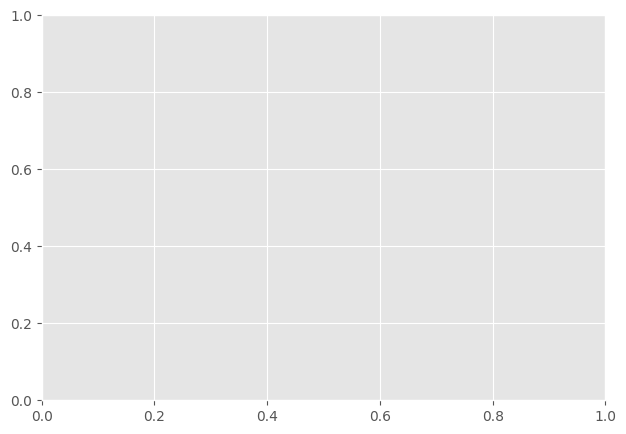

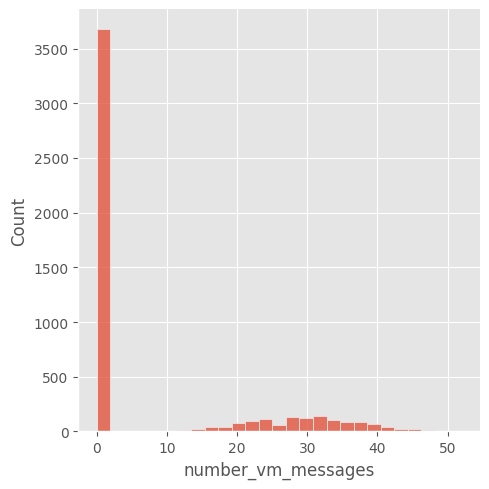



service quality


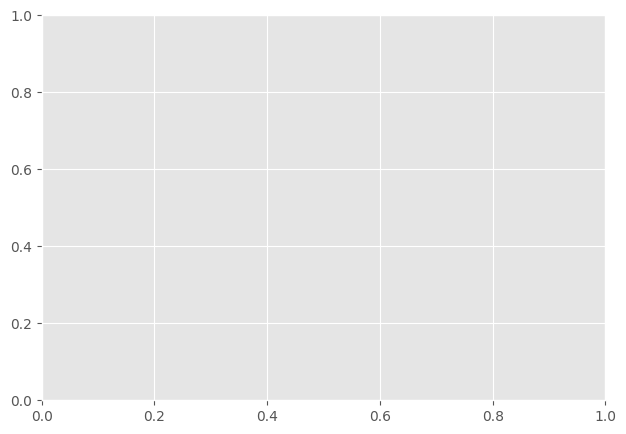

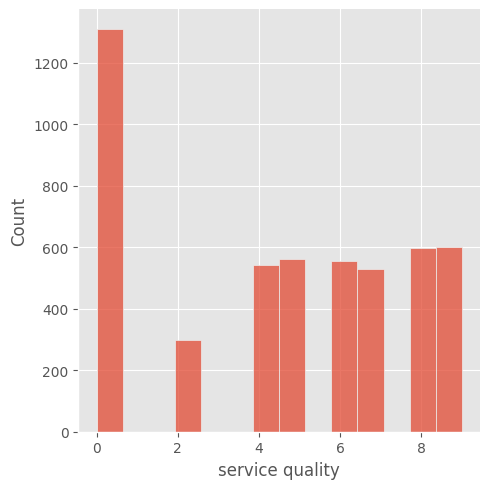



total_day_calls


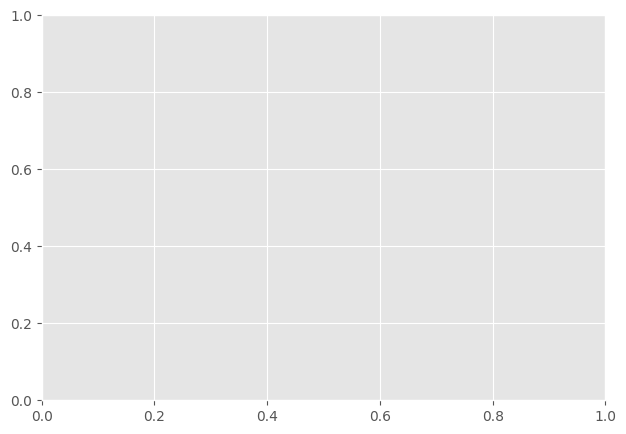

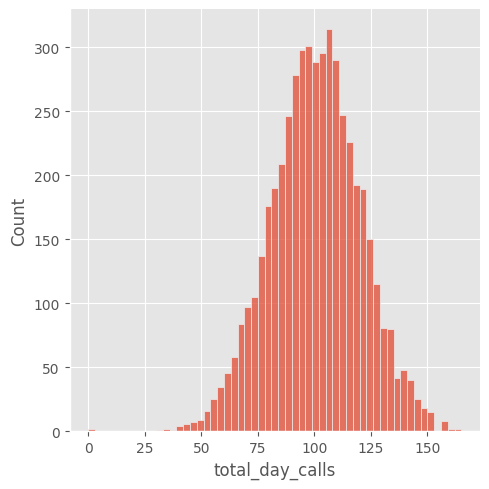



account_length


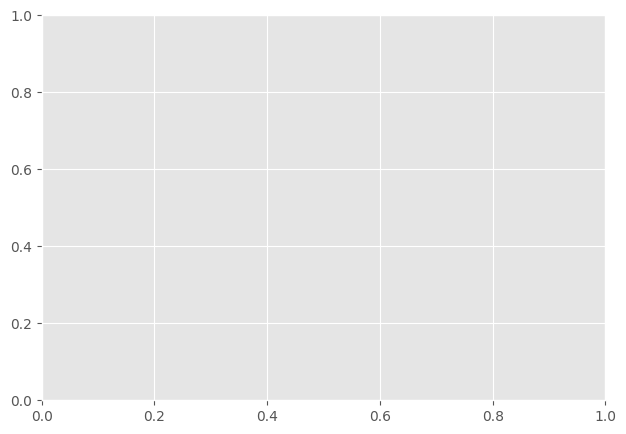

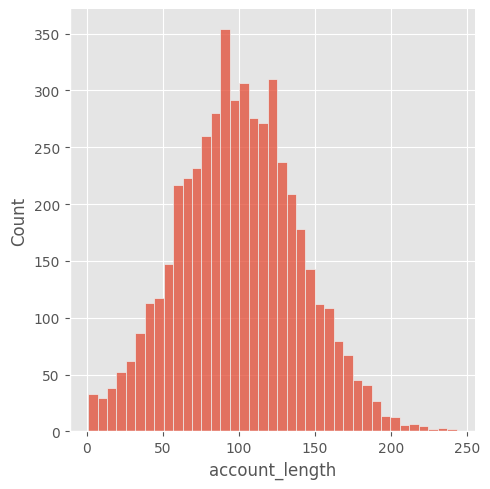



customer_service_calls


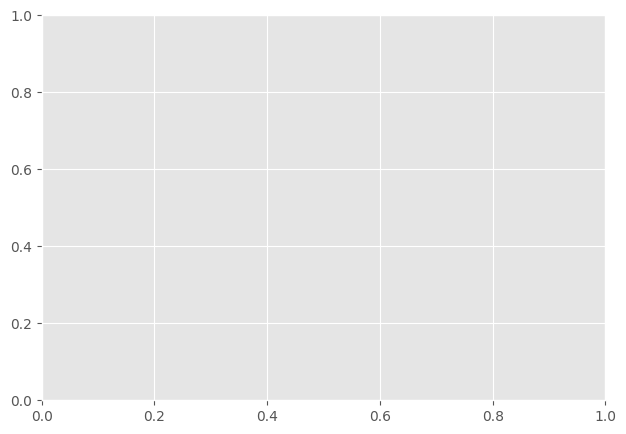

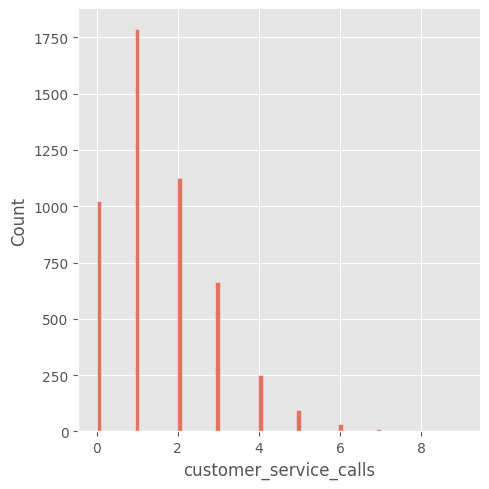

In [49]:
plot_diagram(chatterbox , num_features)

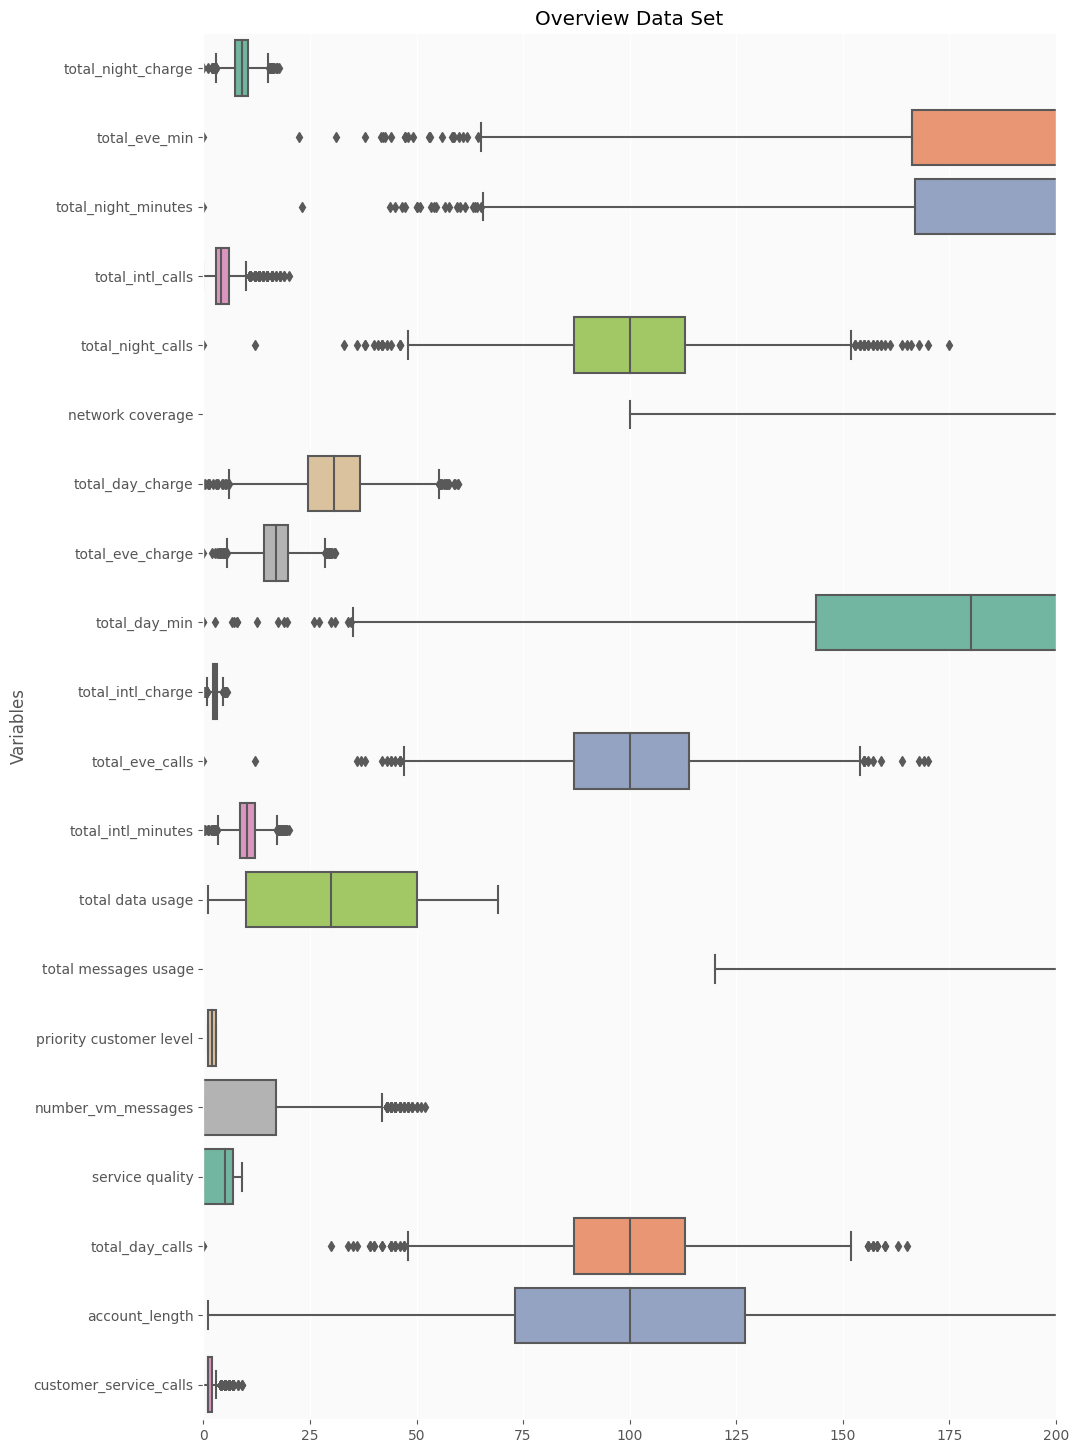

In [50]:
outliers_plot(chatterbox[num_features])

no outliers in the account length

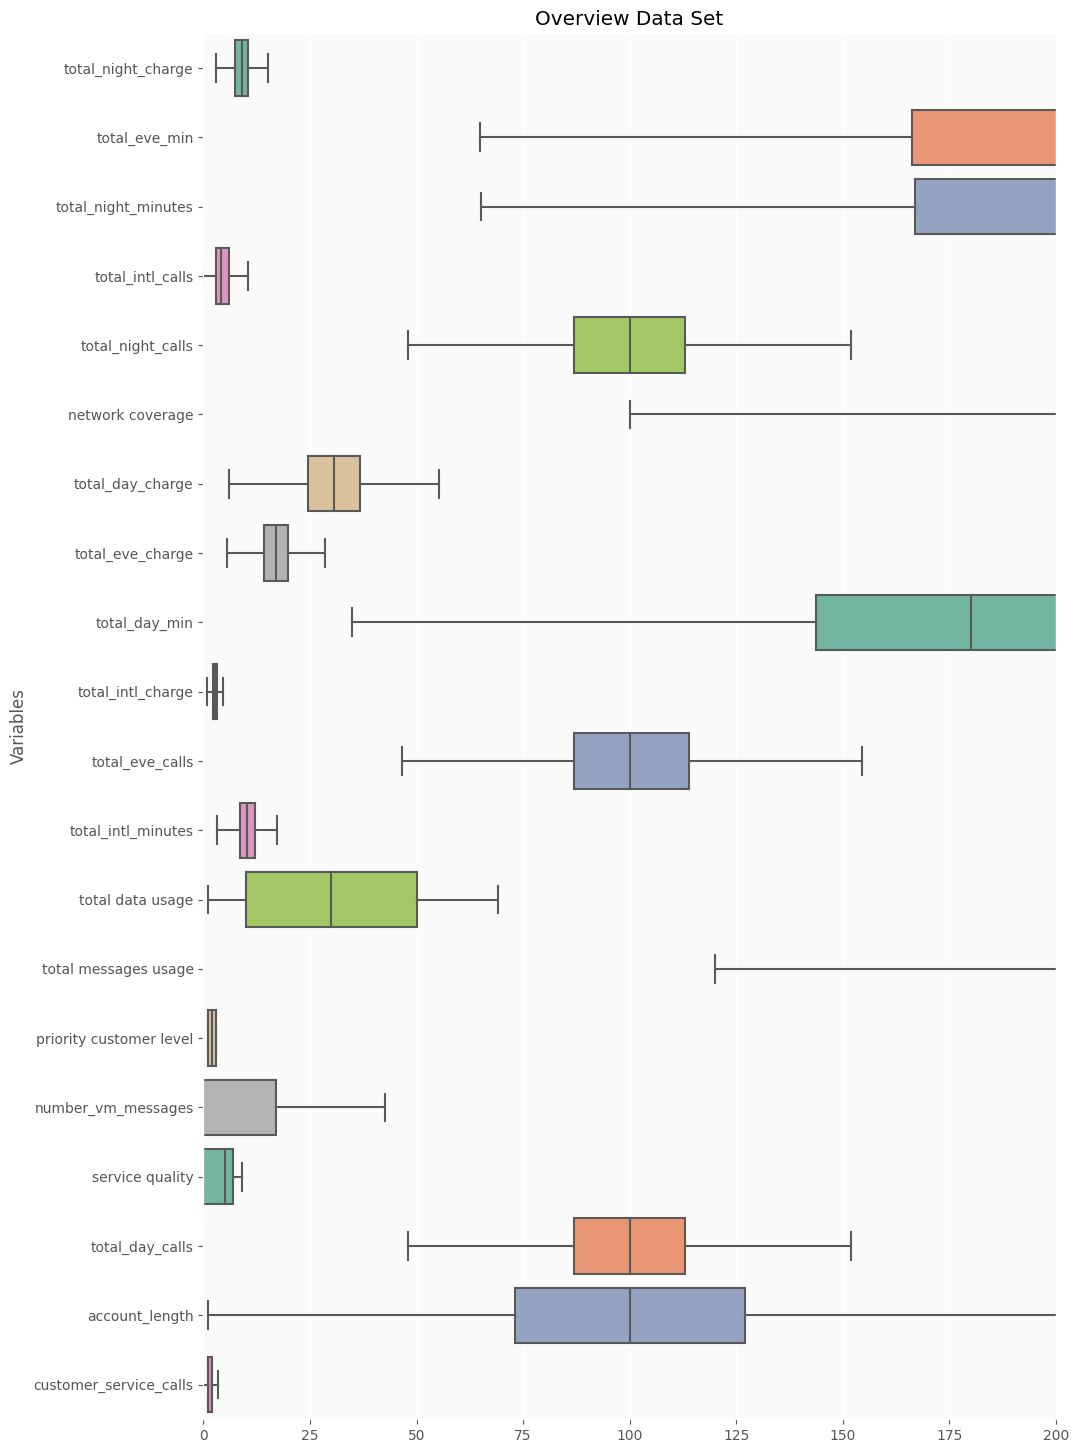

In [51]:
chatterbox = iqr(chatterbox, num_features)
outliers_plot(chatterbox[num_features])

# **Feature Engineering**

In [52]:
chatterbox['total_mins'] = chatterbox['total_day_min'] + chatterbox['total_eve_min'] + chatterbox['total_night_minutes']
chatterbox['total_calls'] = chatterbox['total_day_calls'] + chatterbox['total_eve_calls'] + chatterbox['total_night_calls']
chatterbox['total_charge'] = chatterbox['total_day_charge'] + chatterbox['total_eve_charge'] + chatterbox['total_night_charge']
chatterbox['avg_min_per_call'] = chatterbox['total_mins']  / chatterbox['total_calls']

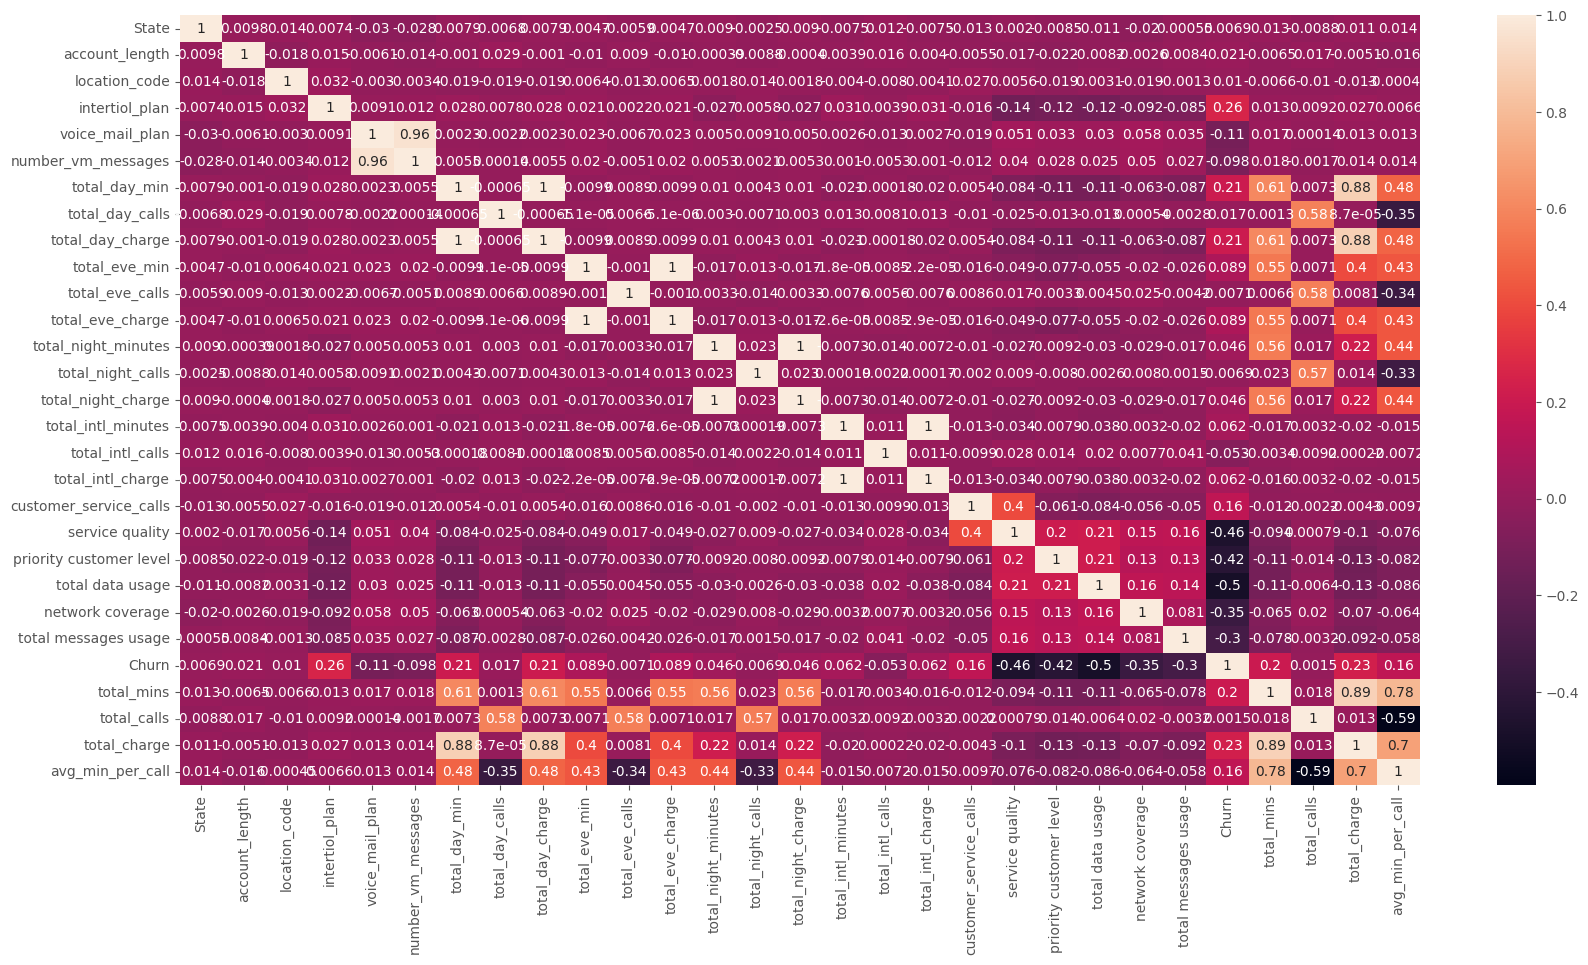

In [53]:
def show_correlations(dataframe, show_chart = True):
    fig = plt.figure(figsize = (20,10))
    corr = dataframe.corr()
    if show_chart == True:
        sns.heatmap(corr, 
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values,
                    annot=True)
    return corr

col = list(chatterbox.columns)
correlation_df = show_correlations(chatterbox[col],show_chart=True)

number)vm_messages - voice_mail_plan

total_day_charge - total_day_min

total_eve_charge - total_eve_min

total_night_charge - total_night_minuts

total_intl_charge - total_intl_minutes

total_charge - total_mins

In [54]:
# drop voice mail plan
# drop total day charge
# drop total eve charge
# drop total night charge
# drop total intl charge
# drop total charge

voice_mail_plan = chatterbox['voice_mail_plan']
total_day_charge = chatterbox['total_day_charge']
total_eve_charge = chatterbox['total_eve_charge']
total_night_charge = chatterbox['total_night_charge']
total_intl_charge = chatterbox['total_intl_charge']
total_charge = chatterbox['total_charge']
chatterbox = chatterbox.drop(columns=['voice_mail_plan', 'total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge'])


In [55]:
y = chatterbox['Churn']
X = chatterbox.drop(columns=['Churn'])

In [56]:
X

,State,account_length,location_code,intertiol_plan,number_vm_messages,total_day_min,total_day_calls,total_eve_min,total_eve_calls,total_night_minutes,...,customer_service_calls,service quality,priority customer level,total data usage,network coverage,total messages usage,total_mins,total_calls,total_charge,avg_min_per_call
0,16,128.0,415,0,25.0,265.1,110.0,197.4000,99.0,244.7,...,1.0,9.0,2.0,1.0,173.0,266.0,707.2000,300.0,72.86,2.357333
1,35,107.0,415,0,26.0,161.6,123.0,195.5000,103.0,254.4,...,1.0,6.0,2.0,19.0,271.0,361.0,611.5000,329.0,55.54,1.858663
2,31,137.0,415,0,0.0,243.4,114.0,121.2000,110.0,162.6,...,0.0,0.0,1.0,53.0,805.0,623.0,527.2000,328.0,59.00,1.607317
3,35,84.0,408,1,0.0,299.4,71.0,64.7875,88.0,196.9,...,2.0,6.0,3.0,17.0,896.0,686.0,561.0875,248.0,65.26,2.262450
4,36,75.0,415,1,0.0,166.7,113.0,148.3000,122.0,186.9,...,3.0,6.0,3.0,62.0,944.0,140.0,501.9000,356.0,49.36,1.409831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,11,50.0,408,0,40.0,235.7,127.0,223.0000,126.0,297.5,...,2.0,6.0,2.0,6.0,167.0,459.0,756.2000,369.0,72.42,2.049322
4996,49,152.0,415,0,0.0,184.2,90.0,256.8000,73.0,213.6,...,3.0,0.0,1.0,5.0,381.0,133.0,654.6000,276.0,62.75,2.371739
4997,7,61.0,415,0,0.0,140.6,89.0,172.8000,128.0,212.4,...,1.0,5.0,2.0,40.0,943.0,145.0,525.8000,314.0,48.15,1.674522
4998,7,109.0,510,0,0.0,188.8,67.0,171.7000,92.0,224.4,...,0.0,0.0,3.0,31.0,910.0,216.0,584.9000,248.0,56.79,2.358468


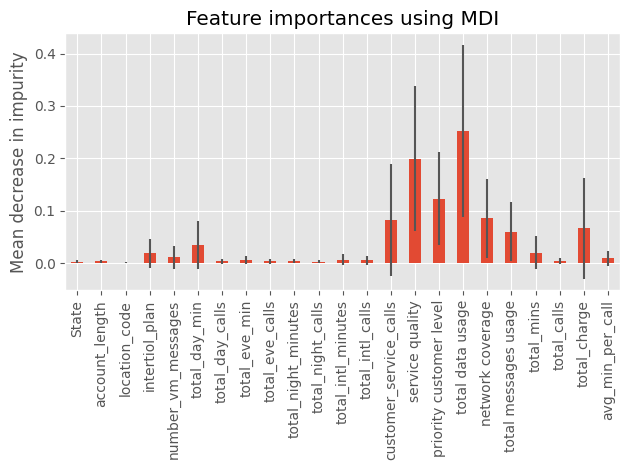

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(forest.feature_importances_, index=list(X.columns))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [58]:
location_code = chatterbox['location_code']
chatterbox = chatterbox.drop(columns=['location_code'])

# **Model Building**

# RandomForestClassifier

In [59]:
y = chatterbox['Churn']
X = chatterbox.drop(columns=['Churn'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

model_rf = RandomForestClassifier(n_estimators=1000, 
                                  oob_score = True, 
                                  n_jobs = -1,
                                  random_state =50, 
                                  max_features = "auto",
                                  max_leaf_nodes = 30)

model_rf.fit(X_train, y_train)
train_predict_rf1 = model_rf.predict(X_test)

print ("scores for RandomForestClassifier Attempt:1 ")

print("accuracy score:", accuracy_score(y_test, train_predict_rf1))
print("precision score:", precision_score(y_test, train_predict_rf1))
print("average precision score:", average_precision_score(y_test, train_predict_rf1))
print("f1 score:", f1_score(y_test, train_predict_rf1))
print("recall score:", recall_score(y_test, train_predict_rf1))

c:\Users\agskp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


scores for RandomForestClassifier Attempt:1 
accuracy score: 0.997
precision score: 0.9791666666666666
average precision score: 0.9791666666666666
f1 score: 0.9894736842105264
recall score: 1.0


# ADABoostClassifier

In [60]:
y = chatterbox['Churn']
X = chatterbox.drop(columns=['Churn'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


model_ada = AdaBoostClassifier()
model_ada.fit(X_train,y_train)
train_predict_ada = model_ada.predict(X_test)

print ("scores for ADA Boost : ")
print("accuracy score:", accuracy_score(y_test, train_predict_ada))
print("precision score:", precision_score(y_test, train_predict_ada))
print("average precision score:", average_precision_score(y_test, train_predict_ada))
print("f1 score:", f1_score(y_test, train_predict_ada))
print("recall score:", recall_score(y_test, train_predict_ada))

scores for ADA Boost : 
accuracy score: 0.997
precision score: 0.9791666666666666
average precision score: 0.9791666666666666
f1 score: 0.9894736842105264
recall score: 1.0


# CatBoostClassifier

In [61]:
y = chatterbox['Churn']
X = chatterbox.drop(columns=['Churn'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

cat_model = CatBoostClassifier( verbose=50)
cat_model.fit(X_train, y_train)
train_predict_cat = cat_model.predict(X_test)

print ("scores for CatBoost without tuning: ")
print("accuracy score:", accuracy_score(y_test, train_predict_cat))
print("precision score:", precision_score(y_test, train_predict_cat))
print("average precision score:", average_precision_score(y_test, train_predict_cat))
print("f1 score:", f1_score(y_test, train_predict_cat))
print("recall score:", recall_score(y_test, train_predict_cat))

Learning rate set to 0.018621
0:	learn: 0.6419055	total: 15.3ms	remaining: 15.2s
50:	learn: 0.0304143	total: 684ms	remaining: 12.7s
100:	learn: 0.0071576	total: 1.3s	remaining: 11.6s
150:	learn: 0.0040324	total: 2.04s	remaining: 11.5s
200:	learn: 0.0028174	total: 2.43s	remaining: 9.67s
250:	learn: 0.0019460	total: 2.7s	remaining: 8.07s
300:	learn: 0.0015927	total: 2.96s	remaining: 6.87s
350:	learn: 0.0013031	total: 3.26s	remaining: 6.04s
400:	learn: 0.0011331	total: 3.71s	remaining: 5.54s
450:	learn: 0.0010323	total: 4.06s	remaining: 4.94s
500:	learn: 0.0009458	total: 4.37s	remaining: 4.35s
550:	learn: 0.0009319	total: 4.67s	remaining: 3.81s
600:	learn: 0.0009279	total: 4.87s	remaining: 3.23s
650:	learn: 0.0009277	total: 5.08s	remaining: 2.72s
700:	learn: 0.0009276	total: 5.27s	remaining: 2.25s
750:	learn: 0.0009276	total: 5.45s	remaining: 1.81s
800:	learn: 0.0009275	total: 5.71s	remaining: 1.42s
850:	learn: 0.0009275	total: 5.97s	remaining: 1.04s
900:	learn: 0.0009275	total: 6.24s	rem

In [62]:
# n_est = [1000, 2000, 3000]
# depth = list(range(4,10,2))

# #create the grid
# grid = {'depth': depth,
#         'iterations':n_est}
# gscv = GridSearchCV (estimator = cat_model, 
#                      param_grid = grid)
# gscv.fit(X_train,y_train)
# print("best parameters: ", gscv.best_params_)

In [63]:
#GridSearchCV results to the model
cat_model_2 = CatBoostClassifier(iterations=3000, 
                               depth=8, 
                               verbose=500)
cat_model_2.fit(X_train, y_train)
train_predict_cat_2 = cat_model_2.predict(X_test)

print ("scores for CatBoost with Tuning Attempt:1")
print("accuracy score:", accuracy_score(y_test, train_predict_cat_2))
print("precision score:", precision_score(y_test, train_predict_cat_2))
print("average precision score:", average_precision_score(y_test, train_predict_cat_2))
print("f1 score:", f1_score(y_test, train_predict_cat_2))
print("recall score:", recall_score(y_test, train_predict_cat_2))

Learning rate set to 0.0068
0:	learn: 0.6763281	total: 24.6ms	remaining: 1m 13s
500:	learn: 0.0032410	total: 5.21s	remaining: 26s
1000:	learn: 0.0011714	total: 9.65s	remaining: 19.3s
1500:	learn: 0.0005561	total: 14.1s	remaining: 14s
2000:	learn: 0.0003684	total: 18.4s	remaining: 9.18s
2500:	learn: 0.0003280	total: 22.8s	remaining: 4.56s
2999:	learn: 0.0003210	total: 27.2s	remaining: 0us
scores for CatBoost with Tuning Attempt:1
accuracy score: 0.997
precision score: 0.9791666666666666
average precision score: 0.9791666666666666
f1 score: 0.9894736842105264
recall score: 1.0


In [64]:
# n_est = [3000,4000,5000]
# depth = [6,7,8,9,10]

# #create the grid
# grid = {'depth': depth,
#         'iterations':n_est}
# gscv = GridSearchCV (estimator = cat_model, 
#                      param_grid = grid)

# #fit the model
# gscv.fit(X_train,y_train)
# print("best parameters: ", gscv.best_params_)

In [65]:
#GridSearchCV results to the model
cat_model_3 = CatBoostClassifier(iterations=4000, 
                               depth=9, 
                               verbose=500)
cat_model_3.fit(X_train, y_train)
train_predict_cat_3 = cat_model_3.predict(X_test)

print ("scores for CatBoost with tuning Attempt:2")
print("accuracy score:", accuracy_score(y_test, train_predict_cat_3))
print("precision score:", precision_score(y_test, train_predict_cat_3))
print("average precision score:", average_precision_score(y_test, train_predict_cat_3))
print("f1 score:", f1_score(y_test, train_predict_cat_3))
print("recall score:", recall_score(y_test, train_predict_cat_3))

Learning rate set to 0.005223
0:	learn: 0.6802169	total: 29.4ms	remaining: 1m 57s
500:	learn: 0.0060075	total: 7.6s	remaining: 53.1s
1000:	learn: 0.0021359	total: 15.2s	remaining: 45.4s
1500:	learn: 0.0012525	total: 22.4s	remaining: 37.3s
2000:	learn: 0.0008397	total: 29.8s	remaining: 29.8s
2500:	learn: 0.0006195	total: 37.5s	remaining: 22.5s
3000:	learn: 0.0004834	total: 45s	remaining: 15s
3500:	learn: 0.0003998	total: 52.2s	remaining: 7.44s
3999:	learn: 0.0003576	total: 59.5s	remaining: 0us
scores for CatBoost with tuning Attempt:2
accuracy score: 0.997
precision score: 0.9791666666666666
average precision score: 0.9791666666666666
f1 score: 0.9894736842105264
recall score: 1.0


In [66]:
cat_model_4 = CatBoostClassifier(iterations=10000, 
                               depth=8, 
                               verbose=1000)
cat_model_4.fit(X_train, y_train)
train_predict_cat_4 = cat_model_4.predict(X_test)

print ("scores for CatBoost with tuning Attepmt:3")
print("accuracy score:", accuracy_score(y_test, train_predict_cat_4))
print("precision score:", precision_score(y_test, train_predict_cat_4))
print("average precision score:", average_precision_score(y_test, train_predict_cat_4))
print("f1 score:", f1_score(y_test, train_predict_cat_4))
print("recall score:", recall_score(y_test, train_predict_cat_4))

Learning rate set to 0.002254
0:	learn: 0.6875360	total: 19.2ms	remaining: 3m 11s
1000:	learn: 0.0063691	total: 8.48s	remaining: 1m 16s
2000:	learn: 0.0022296	total: 17.1s	remaining: 1m 8s
3000:	learn: 0.0012237	total: 25.3s	remaining: 58.9s
4000:	learn: 0.0007175	total: 33.4s	remaining: 50.1s
5000:	learn: 0.0004756	total: 41.8s	remaining: 41.8s
6000:	learn: 0.0003678	total: 50.2s	remaining: 33.4s
7000:	learn: 0.0003232	total: 58.3s	remaining: 25s
8000:	learn: 0.0003144	total: 1m 5s	remaining: 16.5s
9000:	learn: 0.0003076	total: 1m 13s	remaining: 8.19s
9999:	learn: 0.0003045	total: 1m 22s	remaining: 0us
scores for CatBoost with tuning Attepmt:3
accuracy score: 0.997
precision score: 0.9791666666666666
average precision score: 0.9791666666666666
f1 score: 0.9894736842105264
recall score: 1.0


# **KNN Classifier**

In [67]:
scaler = StandardScaler()

In [68]:
y = chatterbox['Churn']
X = chatterbox.drop(columns=['Churn'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [69]:
range_k = range(1,15)
scores = {}
scores_list = []

for k in range_k:
   classifier = KNeighborsClassifier(n_neighbors=k)
   classifier.fit(X_train, y_train)

   y_pred = classifier.predict(X_test)
   scores[k] = metrics.accuracy_score(y_test, y_pred)
   scores_list.append(metrics.accuracy_score(y_test,y_pred))

result = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)

result1 = metrics.classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)

Confusion Matrix:
[[854   5]
 [  7 134]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       859
           1       0.96      0.95      0.96       141

    accuracy                           0.99      1000
   macro avg       0.98      0.97      0.98      1000
weighted avg       0.99      0.99      0.99      1000



Text(0, 0.5, 'Accuracy')

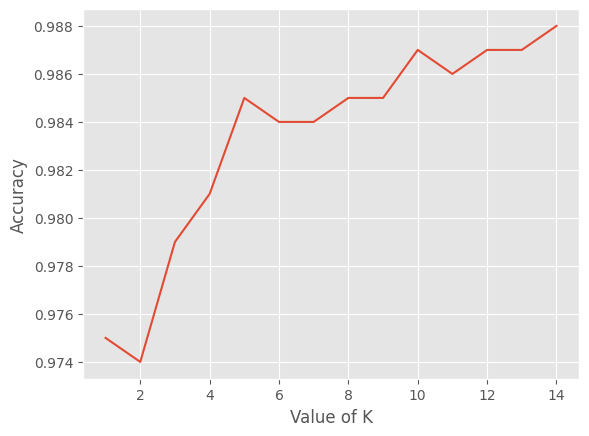

In [70]:
plt.plot(range_k, scores_list)
plt.xlabel("Value of K")
plt.ylabel("Accuracy")

In [85]:
knn_classifier = KNeighborsClassifier(n_neighbors = 14)
knn_classifier.fit(X_train, y_train)
train_predict_knn = knn_classifier.predict(X_test)

print ("scores for KNN Classifier Attepmt:1")
print("accuracy score:", accuracy_score(y_test, train_predict_knn))
print("precision score:", precision_score(y_test, train_predict_knn))
print("average precision score:", average_precision_score(y_test, train_predict_knn))
print("f1 score:", f1_score(y_test, train_predict_knn))
print("recall score:", recall_score(y_test, train_predict_knn))

scores for KNN Classifier Attepmt:1
accuracy score: 0.907
precision score: 0.7857142857142857
average precision score: 0.4427811550151976
f1 score: 0.5866666666666668
recall score: 0.46808510638297873


# **Support Vector Machine**

In [72]:
y = chatterbox['Churn']
X = chatterbox.drop(columns=['Churn'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

svc_classifier = SVC()  
svc_classifier.fit(X_train, y_train)  
train_predict_svc_1 = svc_classifier.predict(X_test)

print ("scores for Support Vector Classifier:")
print("accuracy score:", accuracy_score(y_test, train_predict_svc_1))
print("precision score:", precision_score(y_test, train_predict_svc_1))
print("average precision score:", average_precision_score(y_test, train_predict_svc_1))
print("f1 score:", f1_score(y_test, train_predict_svc_1))
print("recall score:", recall_score(y_test, train_predict_svc_1))

scores for Support Vector Classifier:
accuracy score: 0.993
precision score: 0.9652777777777778
average precision score: 0.9535858944050434
f1 score: 0.9754385964912281
recall score: 0.9858156028368794


# LGBM Classifier

In [73]:
y = chatterbox['Churn']
X = chatterbox.drop(columns=['Churn'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

lgb_model_1 = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
lgb_model_1.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],verbose=20,eval_metric='logloss')
print('Training accuracy {:.4f}'.format(lgb_model_1.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgb_model_1.score(X_test,y_test)))

c:\Users\agskp\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's binary_logloss: 0.0431067	valid_0's binary_logloss: 0.0476783
[40]	training's binary_logloss: 0.0077187	valid_0's binary_logloss: 0.0173322
[60]	training's binary_logloss: 0.00140177	valid_0's binary_logloss: 0.0158742
[80]	training's binary_logloss: 0.000248767	valid_0's binary_logloss: 0.0193992
[100]	training's binary_logloss: 4.55584e-05	valid_0's binary_logloss: 0.0236957
Training accuracy 1.0000
Testing accuracy 0.9970


In [74]:
train_predict_lgb_1 = lgb_model_1.predict(X_test)
print ("scores for train_predict_lgb_1:")
print("accuracy score:", accuracy_score(y_test, train_predict_lgb_1))
print("precision score:", precision_score(y_test, train_predict_lgb_1))
print("average precision score:", average_precision_score(y_test, train_predict_lgb_1))
print("f1 score:", f1_score(y_test, train_predict_lgb_1))
print("recall score:", recall_score(y_test, train_predict_lgb_1))

scores for train_predict_lgb_1:
accuracy score: 0.997
precision score: 0.9791666666666666
average precision score: 0.9791666666666666
f1 score: 0.9894736842105264
recall score: 1.0


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

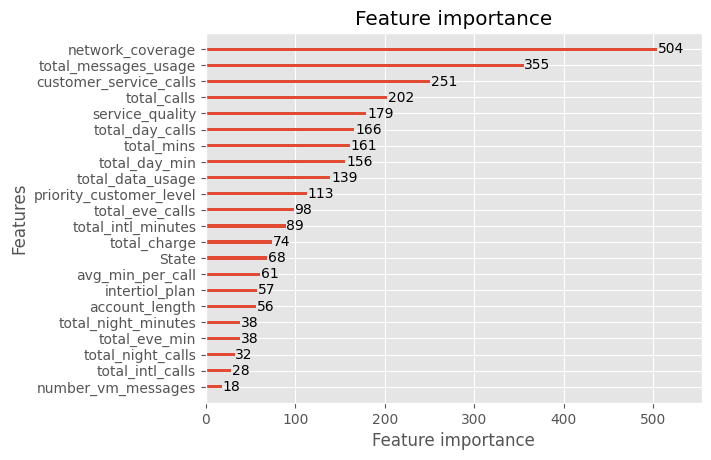

In [75]:
lgb.plot_importance(lgb_model_1)

In [76]:
lgb_model_2 = lgb.LGBMClassifier(learning_rate=0.09,
                                 max_depth=-5,
                                 random_state=42, 
                                 iterations=15, 
                                 binary_logless=0.18)
lgb_model_2.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=20,eval_metric='logloss')
print('Training accuracy {:.4f}'.format(lgb_model_2.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgb_model_2.score(X_test,y_test)))

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: binary_logless
[20]	training's binary_logloss: 0.0431067	valid_0's binary_logloss: 0.0476783
[40]	training's binary_logloss: 0.0077187	valid_0's binary_logloss: 0.0173322
[60]	training's binary_logloss: 0.00140177	valid_0's binary_logloss: 0.0158742
[80]	training's binary_logloss: 0.000248767	valid_0's binary_logloss: 0.0193992
[100]	training's binary_logloss: 4.55584e-05	valid_0's binary_logloss: 0.0236957
Training accuracy 1.0000
Testing accuracy 0.9970


c:\Users\agskp\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [77]:
train_pred_lgb_2 = lgb_model_2.predict(X_test)
print ("scores for LGBM Classifier with tuning Attempt:2 ")
result = metrics.confusion_matrix(y_test, train_pred_lgb_2)
print("Confusion Matrix:")
print(result)

result1 = metrics.classification_report(y_test, train_pred_lgb_2)
print("Classification Report:",)
print (result1)

scores for LGBM Classifier with tuning Attempt:2 
Confusion Matrix:
[[856   3]
 [  0 141]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       859
           1       0.98      1.00      0.99       141

    accuracy                           1.00      1000
   macro avg       0.99      1.00      0.99      1000
weighted avg       1.00      1.00      1.00      1000



In [78]:
# learning_rate = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
# max_depth = [1,2,3,4,5,6,7,8,9,10]

# lgb_model_3 = lgb.LGBMClassifier(random_state=42)

# #create the grid
# grid = {'max_depth': max_depth,
#         'learning_rate':learning_rate,
#         'iterations': 15, 
#         'binary_logless': 0.18
#        }

# gridParams = {
#     'learning_rate': [0.005, 0.01],
#     'n_estimators': [8,16,24],
#     'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
#     'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
#     'objective' : ['binary'],
#     'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
#     }

# gscv = GridSearchCV(lgb_model_3, gridParams, verbose=1, cv=4, n_jobs=-1)


# #fit the model
# gscv.fit(X_train,y_train)
# print("best parameters:" gscv.best_params_)

In [79]:
lgb_model_3 = lgb.LGBMClassifier(boosting_type='gbdt',
                              learning_rate=0.005,
                              max_bin=255,
                              random_state=42, 
                              n_estimators=8, 
                              num_leaves=6,
                              objective='binary')
lgb_model_3.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=20,eval_metric='logloss')
print('Training accuracy {:.4f}'.format(lgb_model_3.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgb_model_3.score(X_test,y_test)))

Training accuracy 0.8585
Testing accuracy 0.8590


c:\Users\agskp\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [80]:
train_predict_lgb_3 = lgb_model_3.predict(X_test)
result = metrics.confusion_matrix(y_test, train_predict_lgb_3)
print("Confusion Matrix:")
print(result)

result1 = metrics.classification_report(y_test, train_predict_lgb_3)
print("Classification Report:",)
print (result1)

Confusion Matrix:
[[859   0]
 [141   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       859
           1       0.00      0.00      0.00       141

    accuracy                           0.86      1000
   macro avg       0.43      0.50      0.46      1000
weighted avg       0.74      0.86      0.79      1000



c:\Users\agskp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\agskp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\agskp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [81]:
# print ("scores for LGBM Classifier with tuning Attempt:3 ")
# print("accuracy score:", accuracy_score(y_test, train_predict_lgb_3))
# print("precision score:", precision_score(y_test, train_predict_lgb_3))
# print("average precision score:", average_precision_score(y_test, train_predict_lgb_3))
# print("f1 score:", f1_score(y_test, train_predict_lgb_3))
# print("recall score:", recall_score(y_test, train_predict_lgb_3))

In [82]:
lgb_model_4 = lgb.LGBMClassifier(n_estimators=40, 
                                 learning_rate=0.02,
                                 max_depth=8,
                                 random_state=42)
lgb_model_4.fit(X_train,y_train)

train_predict_lgb_4 = lgb_model_4.predict(X_test)

print ("scores for LGBM Classifier with tuning Attempt:4 ")
print("accuracy score:", accuracy_score(y_test, train_predict_lgb_4))
print("precision score:", precision_score(y_test, train_predict_lgb_4))
print("average precision score:", average_precision_score(y_test, train_predict_lgb_4))
print("f1 score:", f1_score(y_test, train_predict_lgb_4))
print("recall score:", recall_score(y_test, train_predict_lgb_4))

scores for LGBM Classifier with tuning Attempt:4 
accuracy score: 0.996
precision score: 0.9790209790209791
average precision score: 0.9730775678222487
f1 score: 0.9859154929577465
recall score: 0.9929078014184397


In [83]:
lgb_model_5 = lgb.LGBMClassifier(n_estimators=1400, 
                                 learning_rate=0.02,
                                 max_depth=6,
                                 random_state=42,
                                 objective='binary')
lgb_model_5.fit(X_train,y_train)

train_predict_lgb_5 = lgb_model_5.predict(X_test)

print ("scores for LGBM Classifier with tuning Attempt:5 ")
print("accuracy score:", accuracy_score(y_test, train_predict_lgb_5))
print("precision score:", precision_score(y_test, train_predict_lgb_5))
print("average precision score:", average_precision_score(y_test, train_predict_lgb_5))
print("f1 score:", f1_score(y_test, train_predict_lgb_5))
print("recall score:", recall_score(y_test, train_predict_lgb_5))

scores for LGBM Classifier with tuning Attempt:5 
accuracy score: 0.997
precision score: 0.9791666666666666
average precision score: 0.9791666666666666
f1 score: 0.9894736842105264
recall score: 1.0


In [84]:
X.columns

Index(['State', 'account_length', 'intertiol_plan', 'number_vm_messages',
       'total_day_min', 'total_day_calls', 'total_eve_min', 'total_eve_calls',
       'total_night_minutes', 'total_night_calls', 'total_intl_minutes',
       'total_intl_calls', 'customer_service_calls', 'service quality',
       'priority customer level', 'total data usage', 'network coverage',
       'total messages usage', 'total_mins', 'total_calls', 'total_charge',
       'avg_min_per_call'],
      dtype='object')